# Chapter 1: Using Local Data with fast.ai

This notebook demonstrates how to use fast.ai with data that has already been downloaded locally.

In [1]:
# Import the necessary libraries
from fastai.vision.all import *

## Using Local Data

We'll use the Oxford-IIIT Pet Dataset that we've already downloaded. Instead of using `untar_data()`, we'll directly point to the local path.

In [2]:
# Set the path to the local data directory
path = Path('/home/satishthakur/.fastai/data/oxford-iiit-pet')
path.exists()

True

In [3]:
# Look at what's in the dataset
Path(path).ls()

(#2) [Path('/home/satishthakur/.fastai/data/oxford-iiit-pet/images'),Path('/home/satishthakur/.fastai/data/oxford-iiit-pet/annotations')]

In [4]:
# Look at the images directory
Path(path/'images').ls()[:5]

(#5) [Path('/home/satishthakur/.fastai/data/oxford-iiit-pet/images/Bengal_84.jpg'),Path('/home/satishthakur/.fastai/data/oxford-iiit-pet/images/great_pyrenees_176.jpg'),Path('/home/satishthakur/.fastai/data/oxford-iiit-pet/images/Ragdoll_185.jpg'),Path('/home/satishthakur/.fastai/data/oxford-iiit-pet/images/Russian_Blue_109.jpg'),Path('/home/satishthakur/.fastai/data/oxford-iiit-pet/images/great_pyrenees_186.jpg')]

## Data Preparation

Now we'll prepare the data for our model.

In [5]:
# Function to get the label from the filename
def is_cat(fname):
    # Extract just the file name from the path
    name = str(fname.name)
    # In this dataset, filenames that start with uppercase are cats
    return name[0].isupper()

In [6]:
# Create a DataBlock
pets = DataBlock(blocks=(ImageBlock, CategoryBlock),
                 get_items=get_image_files,
                 splitter=RandomSplitter(valid_pct=0.2, seed=42),
                 get_y=is_cat,
                 item_tfms=Resize(224))

In [7]:
# Create the DataLoaders
dls = pets.dataloaders(path/"images")

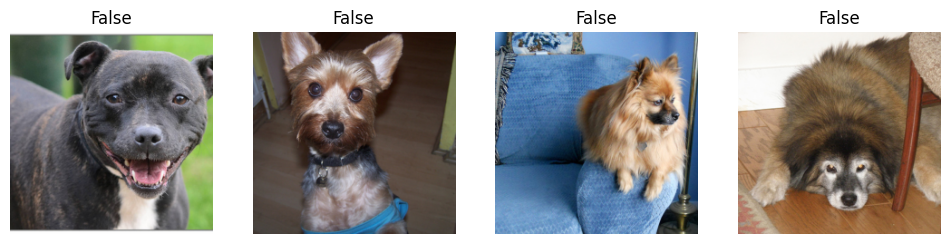

In [8]:
# Show a batch of images
dls.show_batch(max_n=4, nrows=1)

## Let's inspect our data a bit more

In [9]:
# Get some information about our data
print(f"Total images: {len(get_image_files(path/'images'))}")
print(f"Training images: {len(dls.train_ds)}")
print(f"Validation images: {len(dls.valid_ds)}")
print(f"Classes: {dls.vocab}")

Total images: 7390
Training images: 5912
Validation images: 1478
Classes: [False, True]


Number of cat images: 2400
Number of dog images: 4990


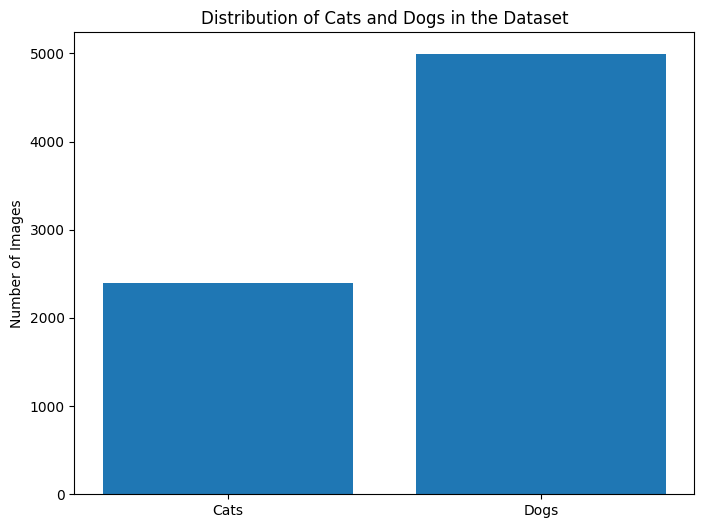

In [10]:
# Count how many cats and dogs we have
cats = [is_cat(f) for f in get_image_files(path/'images')].count(True)
dogs = [is_cat(f) for f in get_image_files(path/'images')].count(False)

print(f"Number of cat images: {cats}")
print(f"Number of dog images: {dogs}")

# Visualize the distribution
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.bar(['Cats', 'Dogs'], [cats, dogs])
plt.title('Distribution of Cats and Dogs in the Dataset')
plt.ylabel('Number of Images')
plt.show()

## Training a Model

Now we'll train a model to classify images as cats or dogs.

In [11]:
# Create and train the model
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /home/satishthakur/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 83.3M/83.3M [00:01<00:00, 48.1MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.145579,0.030667,0.008796,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.062947,0.030276,0.010825,00:18


## Using the Model for Inference

Now let's use our trained model to make predictions.

In [12]:
# Get validation images and labels
x, y = dls.valid.one_batch()
print(f"Batch shape: {x.shape}, Labels shape: {y.shape}")

Batch shape: torch.Size([64, 3, 224, 224]), Labels shape: torch.Size([64])


In [13]:
# Make predictions on the validation set
preds, targets = learn.get_preds(dl=dls.valid)
print(f"Predictions shape: {preds.shape}")
print(f"Target shape: {targets.shape}")

Predictions shape: torch.Size([1478, 2])
Target shape: torch.Size([1478])


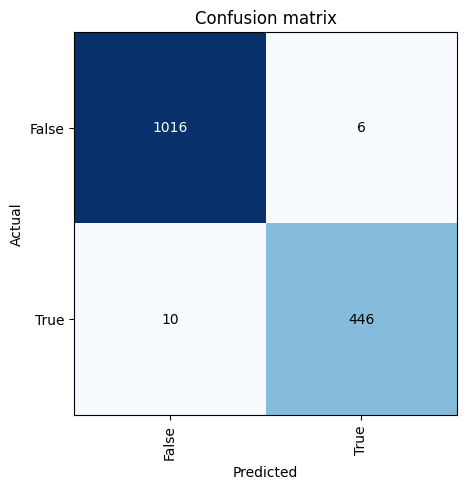

In [14]:
# Plot the confusion matrix
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

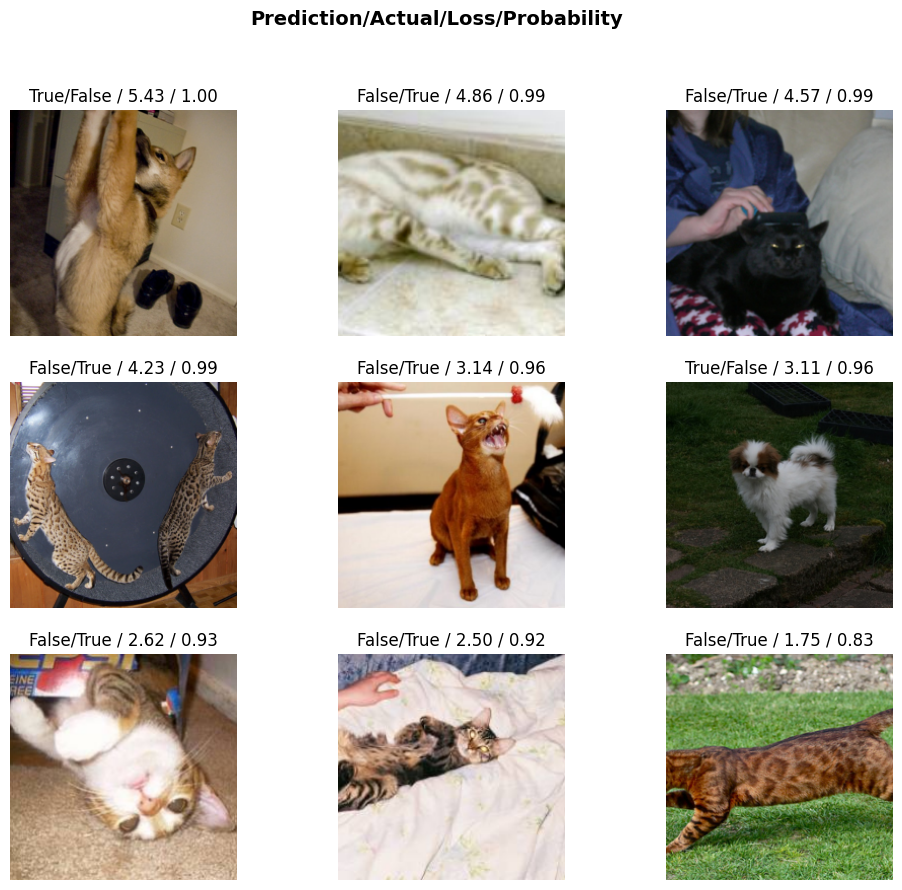

In [15]:
# Show the most confused examples
interp.plot_top_losses(9, figsize=(12, 10))

## Data Augmentation

Let's improve our model with data augmentation.

In [16]:
# Create a new DataBlock with data augmentation
pets_aug = DataBlock(blocks=(ImageBlock, CategoryBlock),
                     get_items=get_image_files,
                     splitter=RandomSplitter(valid_pct=0.2, seed=42),
                     get_y=is_cat,
                     item_tfms=Resize(224),
                     batch_tfms=aug_transforms(mult=2))

In [17]:
# Create the DataLoaders with augmentation
dls_aug = pets_aug.dataloaders(path/"images")

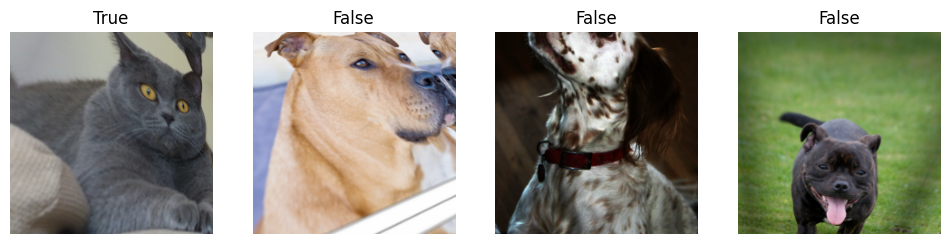

In [18]:
# Show a batch with augmentation
dls_aug.show_batch(max_n=4, nrows=1)

In [19]:
# Train with augmentation
learn_aug = vision_learner(dls_aug, resnet34, metrics=error_rate)
learn_aug.fine_tune(3, base_lr=1e-3)

epoch,train_loss,valid_loss,error_rate,time
0,0.264886,0.029173,0.008796,00:14


epoch,train_loss,valid_loss,error_rate,time
0,0.077776,0.013257,0.002706,00:19
1,0.056898,0.012471,0.004060,00:20
2,0.047280,0.010283,0.002706,00:22


## Saving and Loading the Model

In [20]:
# Save the model
learn_aug.save('pet_classifier_aug')

Path('models/pet_classifier_aug.pth')

In [21]:
# Export the model for production use
learn_aug.export('pet_classifier_export.pkl')

In [22]:
# Load the model from saved state
learn_loaded = vision_learner(dls_aug, resnet34, metrics=error_rate)
learn_loaded.load('pet_classifier_aug')

## Making Predictions on New Images

Let's try to make predictions on some specific images from the validation set.

Filename: wheaten_terrier_154.jpg
True class: Dog


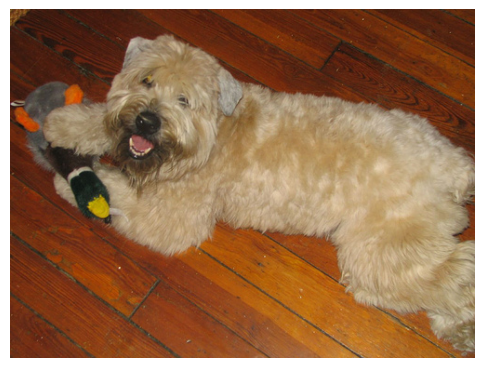

In [23]:
# Get a sample image
sample_images = list(get_image_files(path/'images'))
sample_img = PILImage.create(sample_images[42])

# Display the image
sample_img.show(figsize=(6, 6))
print(f"Filename: {sample_images[42].name}")
print(f"True class: {'Cat' if is_cat(sample_images[42]) else 'Dog'}")

In [24]:
# Make a prediction on this image
pred_class, pred_idx, probs = learn_aug.predict(sample_img)
print(f"Predicted class: {pred_class}")
print(f"Probability: {probs[pred_idx]:.4f}")

Predicted class: False
Probability: 0.9998


## Trying a Different Architecture

Let's experiment with a different model architecture.

In [25]:
# Create and train a model with a different architecture 
learn_resnet50 = vision_learner(dls_aug, resnet50, metrics=error_rate)
learn_resnet50.fine_tune(2)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /home/satishthakur/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 46.2MB/s]


epoch,train_loss,valid_loss,error_rate,time


OutOfMemoryError: CUDA out of memory. Tried to allocate 26.00 MiB. GPU 0 has a total capacity of 7.67 GiB of which 47.12 MiB is free. Including non-PyTorch memory, this process has 6.94 GiB memory in use. Of the allocated memory 6.56 GiB is allocated by PyTorch, and 149.29 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

In [ ]:
# Compare error rates
resnet34_error = learn_aug.validate()[1]
resnet50_error = learn_resnet50.validate()[1]

print(f"ResNet34 error rate: {resnet34_error:.4f}")
print(f"ResNet50 error rate: {resnet50_error:.4f}")


## Going Further: Breed Classification

Instead of just cats vs dogs, we could classify the breeds. Let's sketch out how to approach this.

In [ ]:
# Function to extract the breed from the filename
def get_breed(fname):
    name = fname.name.split('.')[0]
    # Remove digits
    breed = ''.join([c for c in name if not c.isdigit()])
    # Replace underscores with spaces
    return breed.replace('_', ' ')

In [ ]:
# Let's see a few examples
for i in range(5):
    print(f"Filename: {sample_images[i].name}, Breed: {get_breed(sample_images[i])}")

In [ ]:
# Count the number of unique breeds
breeds = [get_breed(f) for f in get_image_files(path/'images')]
unique_breeds = set(breeds)
print(f"Number of unique breeds: {len(unique_breeds)}")
print("Sample breeds:")
for breed in list(unique_breeds)[:10]:
    print(f"- {breed}")

In [ ]:
# This is just an example - to actually train a breed classifier, we would create a new DataBlock
# and train a model similar to what we did for cats vs dogs
breeds_db = DataBlock(blocks=(ImageBlock, CategoryBlock),
                      get_items=get_image_files,
                      splitter=RandomSplitter(valid_pct=0.2, seed=42),
                      get_y=get_breed,
                      item_tfms=Resize(224),
                      batch_tfms=aug_transforms())

## Conclusion

In this notebook, we've learned how to:
- Load data directly from a local path
- Create a DataBlock with appropriate transforms
- Train a model for binary classification (cats vs dogs)
- Explore data augmentation techniques
- Save and load models
- Make predictions on individual images
- Compare different model architectures
- Sketch an approach for a more complex classification task (breeds)

These fundamental skills form the basis for more advanced deep learning tasks.